In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
import cv2
import pickle
%matplotlib inline

In [2]:
# load all data and models
haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')

mean = pickle.load(open('./data/mean_preprocess.pickle','rb'))
model_svm = pickle.load(open('./mode_svc.pickle','rb'))
model_pca = pickle.load(open('./model/pca_50.pickle','rb'))

print('model load sucessfully')
mean.shape

model load sucessfully


()

In [3]:
gender_pre = ['Male','Female']
font = cv2.FONT_HERSHEY_SIMPLEX

In [4]:
def pipeline_model(img,color = 'rgb'):
    # step 2 : convert into gray scale
    if color=='bgr':
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #step 3: crop the faces using haar cascade classifier
    faces = haar.detectMultiScale(gray,1.5,3)
    for x,y,w,h in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2) # drawing rectangle
        roi = gray[y:y+h,x:x+w]
        #step 4 : normalizating
        roi = roi/255.0
        #atep-5 : reshape image as 100 X 100
        if roi.shape[1] >100:
            roi_resize = cv2.resize(roi,(100,100),cv2.INTER_AREA)
            #print(roi_resize.shape)
        else:
            roi_resize = cv2.resize(roi,(100,100),cv2.INTER_CUBIC)
        #step 6: Flattening (1x10000)
        roi_reshape = roi_resize.reshape(1,-1)
        #print(roi_reshape.shape)
        # step 7: Subtract with mean
        roi_mean = roi_reshape-mean
        #step 8: get eigen image
        eigen_img = model_pca.transform(roi_mean)
        #step 9: pass to ML model
        results = model_svm.predict_proba(eigen_img)[0]
        #step 10 
        predict = results.argmax()
        score = results[predict]
        #step: 11
        text = "%s: %0.2f"%(gender_pre[predict],score)
        cv2.putText(img,text,(x,y),font,1,(0,255,0),2)
        return(img)


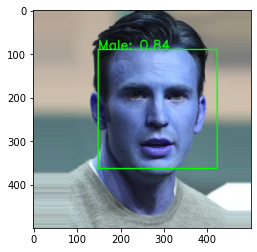

In [5]:
#test data
test_data_path = './data/male_000281.jpg'
# step 1: read the data
img = cv2.imread(test_data_path)
color = 'bgr'
img = pipeline_model(img,color)
plt.imshow(img)

In [6]:
## we will read the image in rgb

In [7]:
from PIL import Image

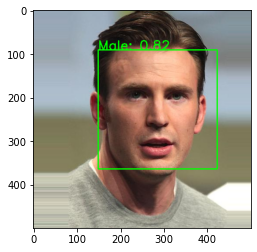

In [13]:
#test data
test_data_path = './data/male_000281.jpg'
# step 1: read the data
img = Image.open(test_data_path)
img = np.array(img)
color = 'bgr'
img = pipeline_model(img,color)
plt.imshow(img)

# Apply pipeline to video

In [10]:
cap = cv2.VideoCapture('./data/video.mp4')
while True:
    ret, frame = cap.read()
    if ret == False:
        break
    frame = pipeline_model(frame,color='bgr')  
    #print(frame)
    try:
        cv2.imshow('Gender detection',frame)
    except:
        continue
    if cv2.waitKey(20)==27:
        break
cv2.destroyAllWindows()   
cap.release()